
# Process Urban Atlas shapefiles to construct training and evaluation datasets

This notebook processess the collection of GIS vector data (shapefiles) on land use classses from the Urban Atlas dataset. The tasks we are interested in are:

* compute basic statistics on each shapefile, such as the spatial extent of the city and the amount of land classified within each city
* construct ground truth test grids (defined as a $25km \times 25km$ square window around the city center)
* define locations to sample images, both for testing (each cell of the ground truth grid) and for training (sampled appropriately from all available data)

In this analysis we work directly with vector data (polygons) for all the above tasks. This is a faster way to process the data for our specific use case of whole-image classification, as opposed to the more accurate approach of rasterizing the data first, then computing classification masks (which is more suited for image segmentation).

Note: to speed up processing over the $\sim 300$ cities in the entire _Urban Atlas_ dataset, we used the parallel processing interface in the `ipythonparallel` package. This requires [setting up an `IPython` cluster](https://ipyparallel.readthedocs.io/en/latest/). The `Jupyter` notebook environment makes it easy to copy objects and data to each node in the cluster by simply including the IPython magic command `%%px --local` at the top of the cell that should be executed on each node. Computation then proceeds with each city processed on a separate node in the cluster (using asynchroneous processing). One can do without this functionality, and run the function `fn_generate_stats()` below in serial mode.

# Setup: packages, paths etc.

In [1]:
import ipyparallel

rc = ipyparallel.Client()
all_engines = rc[:]
lbv = rc.load_balanced_view()

print len(all_engines)

48


In [2]:
# %%px --local

# numeric packages
import numpy as np
import pandas as pd

# filesystem and OS
import sys, os, time
import glob

# plotting
from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

# compression
import gzip
import pickle
import copy

# widgets and interaction
from IPython.display import display, clear_output

import warnings
warnings.filterwarnings('ignore')

# these magics ensure that external modules that are modified are also automatically reloaded
%reload_ext autoreload
%autoreload 2

In [3]:
# %%px --local

# custom module for analyzing Urban Atlas data

import sys
import urbanatlas as ua

In [4]:
# %%px --local

# path to shapefiles

shapefiles_path = "/Users/Tom/Documents/Google Drive/MSc/Deep Learning/Project/urban-environments/dataset-collection/data/shapefiles"

import re

def fn_process_path(s):
    b = os.path.basename(s).split(".")[0]
    country = b.split("_")[0]
    city = " ".join(b.split("_")[1:])
    country = re.findall("[a-zA-Z]+", country)[0]
    return (city, country)

# shapefiles = glob.glob("%s/*/*/*.shp"%shapefiles_path)
shapefiles = glob.glob("%s/*.shp"%shapefiles_path)
shapefiles = {"%s, %s" % fn_process_path(f):f for f in shapefiles}

# path to save data

outPath = "/Users/Tom/Documents/Google Drive/MSc/Deep Learning/Project/urban-environments/dataset-collection/data/extracted-data"

if not os.path.exists(outPath):
    os.makedirs(outPath)
    
# classess used in the Urban Atlas dataset

classes = '''Agricultural + Semi-natural areas + Wetlands
Airports
Construction sites
Continuous Urban Fabric (S.L. > 80%)
Discontinuous Dense Urban Fabric (S.L. : 50% -  80%)
Discontinuous Low Density Urban Fabric (S.L. : 10% - 30%)
Discontinuous Medium Density Urban Fabric (S.L. : 30% - 50%)
Discontinuous Very Low Density Urban Fabric (S.L. < 10%)
Fast transit roads and associated land
Forests
Green urban areas
Industrial, commercial, public, military and private units
Isolated Structures
Land without current use
Mineral extraction and dump sites
Other roads and associated land
Port areas
Railways and associated land
Sports and leisure facilities
Water bodies'''.split("\n")

class2label = {c:i for i,c in enumerate(classes)}
label2class = {i:c for i,c in enumerate(classes)}


# Pipeline for constructing training and evaluation datasets

1. **Construct ground truth rasters for validation**

    Also compute useful stats within windows of L=25,30,50km around the city center:
    * percentage of polygons per class 
    * percentage of classified area per class
    * percentage of classified area vs total area
2. **Generate locations to extract imagery at**

    Our sampling strategy has the following goals:
    * ensure that a uniform $100 \times 100 ~ (25km \times 25km)$ "main grid" is completely sampled (except for where there are no ground truth polygons). We generate samples in this grid first, and assign the ground truth label of the image sampled in each grid cell to the class of the polygon that has the maximum intersection area with that cell; 
    * ensure that the resulting dataset is balanced with respect to the land use classes. The trouble is that the classes are highly imbalanced among the polygons in the dataset (e.g., many more polygons are agricultural land and isolated structures than airports).
    * sample additional polygons apart from the ones in the initial grid, such that only polygons above a certain threshold size are considered (so that we can ensure that the sampled images contain a large enough area of the class they represent). 
    * to ensure higher match between labels and sampled images, sample more images from polygons of larger areas

#### Test functionality for one example city

In [5]:
myname = "barcelona, es"

# read in shapefile
# print(shapefiles)
shapefile = shapefiles[myname]

mycity = ua.UAShapeFile(shapefile, name=myname)

L = mycity.compute_spatial_extent()
print("Spatial extent: %2.2f km.") % L

classified_pct = mycity.compute_classified_area()
print(classified_pct)

Spatial extent: %2.2f km.


TypeError: unsupported operand type(s) for %: 'NoneType' and 'float'

In [6]:
lonmin, latmin, lonmax, latmax = mycity._bounds
city_center = ((latmin+latmax)/2.0, (lonmin+lonmax)/2.0)
mycity_crop = mycity.crop_centered_window(city_center, (25,25))

print mycity_crop._gdf.shape, mycity._gdf.shape

(9702, 8) (12292, 8)


In [ ]:
raster, locations, cur_classes = mycity_crop.extract_class_raster(grid_size=grid_size)
raster.shape

In [7]:
locations_train = mycity.generate_sampling_locations()
locations_train.head()

lon        lat
ITEM                                                                
Agricultural + Semi-natural areas + Wetlands 0  26.135732  44.391057
                                             1  26.005618  44.500945
                                             2  26.094601  44.343247
                                             3  26.080207  44.538688
                                             4  26.061092  44.325839

#### Run pipeline for all cities in the Urban Atlas dataset

In [8]:
%%px --local

# for constructing ground truth raster grids

grid_cell = 100
grid_size = (grid_cell, grid_cell)
window_km = 25

# for generating sampling locations

img_area = (224 * 1.19/ 1000)**2 # in km^2, at zoom level 17
thresh_frac = 0.25 # at least <thresh_frac> % of the image should be covered by a polygon of a given class
thresh_area = img_area * thresh_frac  
# print "Threshold area: %2.2f km^2"%thresh_area

n_classes = len(classes)

N_SAMPLES_PER_CITY  = 25000
N_SAMPLES_PER_CLASS = N_SAMPLES_PER_CITY / n_classes
MAX_SAMPLES_PER_POLY= 50

In [9]:
def fn_generate_stats(shapefile):
    cityname = "%s, %s" % fn_process_path(shapefile)
        
    print "Processing %s"%cityname
    
    savedir = "%s/%s/"%(outPath, cityname)
    if not os.path.exists(savedir):
        os.makedirs(savedir)

#     if len([x for x in os.listdir(savedir) if 'ground_truth_class_raster' in x])>=1:
#         return "Already processed!"
   
    mycity = ua.UAShapeFile(shapefile, name=cityname)
    
    if mycity._gdf is None:
        return "Error reading shapefile %s"%shapefile
     
    # approximate city center by the center of the bounding box of the shapefile
    lonmin, latmin, lonmax, latmax = mycity._bounds
    city_center = ((latmin+latmax)/2.0, (lonmin+lonmax)/2.0)

    # there's some weird issue with the shapefile for Graz
    # lat and lon are inverted?
    if cityname in ["graz, at"]: #not bounds_gdf.contains(Point(city_center[::-1])):
        gdf['geometry'] = gdf['geometry'].apply(\
                lambda p: Polygon((lon,lat) \
                    for (lon,lat) in zip(p.exterior.coords.xy[1], p.exterior.coords.xy[0])))
    
    # compute spatial extent of city and fraction of land classified
    L = mycity.compute_spatial_extent()
    frac_classified = mycity.compute_classified_area()
    frac_classified['pct land classified'] = frac_classified.sum()
    frac_classified['spatial extent'] = L
    frac_classified.to_csv("%s/basic_stats.csv"%savedir)
        
    window = (window_km, window_km)
    mycity_crop = mycity.crop_centered_window(city_center, window)

    # compute ground traster for given window size
    raster, locations_grid, cur_classes = mycity_crop.extract_class_raster(grid_size=grid_size)
    myraster = np.zeros(grid_size + (len(classes),))
    idx = [class2label[c] for k,c in enumerate(cur_classes)]
    myraster[:,:,idx] = raster

    # save data
    np.savez_compressed("%s/ground_truth_class_raster_%dkm.npz"%(savedir,window_km), myraster, classes)
    locations_grid.to_csv("%s/sample_locations_raster_%dkm.csv"%(savedir,window_km), index=False)
 
    # extract sampling locations for training
    locations_train = mycity.generate_sampling_locations(thresh_area=thresh_area, \
                                                         n_samples_per_class=N_SAMPLES_PER_CLASS,\
                                                         max_samples=MAX_SAMPLES_PER_POLY)
    locations_train.to_csv("%s/additional_sample_locations.csv"%(savedir))

In [10]:
shapefile = shapefiles["limoges, fr"]
cityname = "%s, %s" % fn_process_path(shapefile)
print cityname
savedir = "%s/%s/"%(outPath, cityname)
print len([x for x in os.listdir(savedir) if 'ground_truth_class_raster' in x])==3
[x for x in os.listdir(savedir) if 'ground_truth_class_raster' in x]

print shapefile
fn_generate_stats(shapefile)

limoges, fr
True
/home/data/urban-atlas/shapefiles/1/shape/fr024l_limoges.shp
Processing limoges, fr
23332 polygons | 19 land use classes


In [11]:
res = lbv.map_async(fn_generate_stats, shapefiles.values())

In [53]:
res.progress

298

# Plot statistics on all ~300 cities in Urban Atlas


In [14]:
datapath = "/home/data/urban-atlas/extracted-data/"

stats_files = glob.glob("%s/*/basic_stats.csv"%datapath)

basic_stats_df = pd.concat([pd.read_csv(f, header=None).set_index(0).T \
                                for f in stats_files], axis=0)
basic_stats_df.index = [f.split("/")[-2] for f in stats_files]
basic_stats_df.head()

Agricultural + Semi-natural areas + Wetlands  Airports  \
schwerin, de                                          0.329909  0.000523   
stara zagora, bg                                      0.284313  0.008148   
cambridge, uk                                         0.481015  0.001980   
kielce, pl                                            0.265214  0.000148   
turku, fi                                             0.202545  0.000672   

                  Construction sites  Continuous Urban Fabric (S.L. > 80%)  \
schwerin, de                0.000171                              0.001932   
stara zagora, bg            0.002566                              0.036911   
cambridge, uk               0.000893                              0.000099   
kielce, pl                  0.000160                              0.003167   
turku, fi                   0.000626                              0.001301   

                  Discontinuous Dense Urban Fabric (S.L. : 50% -  80%)  \
schwerin, de                                               0.006348      
stara zagora, bg                                           0.017387      
cambridge, uk                                              0.003412      
kielce, pl                                                 0.017085      
turku, fi                                                  0.003929      

                  Discontinuous Low Density Urban Fabric (S.L. : 10% - 30%)  \
schwerin, de                                               0.001569           
stara zagora, bg                                           0.000312           
cambridge, uk                                              0.012261           
kielce, pl                                                 0.000932           
turku, fi                                                  0.016495           

                  Discontinuous Medium Density Urban Fabric (S.L. : 30% - 50%)  \
schwerin, de                                               0.004991              
stara zagora, bg                                           0.002761              
cambridge, uk                                              0.019080              
kielce, pl                                                 0.005661              
turku, fi                                                  0.007025              

                  Discontinuous Very Low Density Urban Fabric (S.L. < 10%)  \
schwerin, de                                               0.000044          
stara zagora, bg                                                NaN          
cambridge, uk                                              0.000278          
kielce, pl                                                 0.000294          
turku, fi                                                  0.007190          

                  Fast transit roads and associated land   Forests  \
schwerin, de                                    0.000631  0.151272   
stara zagora, bg                                     NaN  0.143631   
cambridge, uk                                   0.000601  0.016428   
kielce, pl                                           NaN  0.190908   
turku, fi                                       0.001065  0.284555   

                       ...        Land without current use  \
schwerin, de           ...                        0.000089   
stara zagora, bg       ...                        0.000809   
cambridge, uk          ...                        0.000123   
kielce, pl             ...                        0.000050   
turku, fi              ...                        0.000396   

                  Mineral extraction and dump sites  No data  \
schwerin, de                               0.001100      NaN   
stara zagora, bg                           0.002512      NaN   
cambridge, uk                              0.001205      NaN   
kielce, pl                                 0.002501      NaN   
turku, fi                                  0.002628      NaN   

                  Other roads a

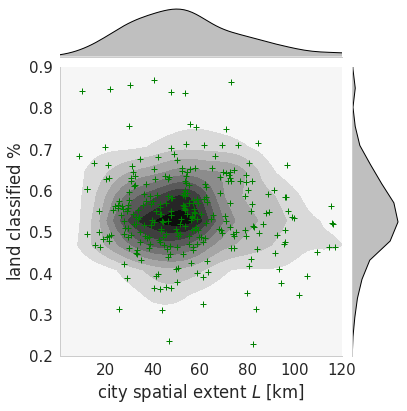

In [15]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1})

plt.figure(figsize=(8,4))
g = sns.jointplot(x=basic_stats_df["spatial extent"], 
                  y=basic_stats_df["pct land classified"], 
                  kind="kde", color="k", 
                  ylim=(0.2,0.9), xlim=(1,120), stat_func=None)
g.plot_joint(plt.scatter, c="green", s=30, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0.7)
g.set_axis_labels("city spatial extent $L$ [km]", "land classified $\%$");

# Pipeline to acquire satellite imagery for the _Urban Environments_ project from Google Maps

This section of the notebook implements a pipeline for acquiring satellite imagery given a list of desired locations. It illustrates how to use the [`satapi` package](https://github.com/adrianalbert/satapi) to collect satellite imagery via the Google Maps Static API. Imagery contains only visual bands.

You can install the `satapi` package directly using `pip`:
```bash
pip install satapi
```

The pipeline code is fairly customized to specifics of how we decided to store location information in the _Urban Environments_ project. However, this can be modified according to the user needs.  

In [15]:
# numeric packages
import numpy as np
import pandas as pd

# filesystem and OS
import sys, os, time
import glob

# plotting
from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline
from IPython.display import display, clear_output

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

# these magics ensure that external modules that are modified are also automatically reloaded
%reload_ext autoreload
%autoreload 2

In [5]:
outPath = "/home/data/urban-atlas/extracted-data"

if not os.path.exists(outPath):
    os.makedirs(outPath)


#### Load info on locations for which to pull imagery

In [2]:
locations_path = "/home/data/urban-atlas/extracted-data/"

grid_location_files = glob.glob("%s/*/sample_locations_raster_25km.csv"%locations_path)
grid_location_files = {f.split("/")[-2]:f for f in grid_location_files}

more_location_files = glob.glob("%s/*/additional_sample_locations.csv"%locations_path)
more_location_files = {f.split("/")[-2]:f for f in more_location_files}

In [3]:
def load_locations(path="./"):
    '''
    This function loads csv files for which each line is contains information on the 
    location of an image to be acquired from Google Maps.
    '''
    grid_locations_df = pd.read_csv(path + "/sample_locations_raster_25km.csv")
    more_locations_df = pd.read_csv(path + "/additional_sample_locations.csv")\
                            .rename(columns={"ITEM":"class"})
    print "Grid samples: %d. Additional samples: %d" % \
            (len(grid_locations_df), len(more_locations_df))
        
    more_locations_df['grid-i'] = np.nan
    more_locations_df['grid-j'] = np.nan
    columns = ["lon", "lat", "grid-i", "grid-j", "class"]
    
#     # locations = more_locations_df[columns]
#     # locations = grid_locations_df[columns]
    locations = pd.concat([grid_locations_df[columns], 
                           more_locations_df[columns]])
    locations = locations.reset_index().drop("index", 1)
    
    return locations

In [6]:
city = "madrid, es"

workdir = "%s/%s" % (outPath, city)
os.chdir(workdir)

locations = load_locations()
print len(locations)

locations.groupby("class").apply(len)

Grid samples: 7840. Additional samples: 26923
34763


class
Agricultural + Semi-natural areas + Wetlands                    8908
Airports                                                         124
Construction sites                                              1459
Continuous Urban Fabric (S.L. > 80%)                             834
Discontinuous Dense Urban Fabric (S.L. : 50% -  80%)            1980
Discontinuous Low Density Urban Fabric (S.L. : 10% - 30%)       2105
Discontinuous Medium Density Urban Fabric (S.L. : 30% - 50%)    2038
Discontinuous Very Low Density Urban Fabric (S.L. < 10%)         871
Fast transit roads and associated land                          1025
Forests                                                         2800
Green urban areas                                               1593
Industrial, commercial, public, military and private units      3370
Isolated Structures                                               61
Mineral extraction and dump sites                               1247
Other roads and associated l

#### Set up client to acquire Google Maps images

In [7]:
import pysatapi
from pysatapi.googlemaps.GoogleMaps import GoogleMaps

In [10]:
import os
googleAPIKey = os.environ['GM_API_KEY']
gmClient = GoogleMaps(key=googleAPIKey)

MAX_REQUESTS = 25000
MAX_TRIES    = 2
img_size     = 224
ZOOM         = 17

#### Extract data for a given city

In [11]:
# cities = ["bucuresti", "berlin", "barcelona", "paris", "athina", \
#           "firenze", "dublin", "london", "tallinn", "bremen"]

cities = ["eindhoven", "london", "belfast", "budapest", "bremen", "roma", "madrid"]

In [12]:
def download_images(locations, prefix="", out_path="./"):
    if not os.path.exists(out_path):
        os.makedirs(out_path)
    
    global n_requests
    
    for i,r in locations.iterrows():
        clear_output(wait=True)
        print "Pulling image %d/%d... (# API requests = %d)"%(i,len(locations), n_requests)
        label, lat, lon, grid_i, grid_j = r['class'], r['lat'], r['lon'], r['grid-i'], r['grid-j']

        basename = "%s/%s/%s_z%d_%2.5f_%2.5f"%(out_path, label, prefix, ZOOM, lat, lon)
        if not np.isnan(grid_i) and not np.isnan(grid_j):
            cur_filename = "%s_grid-i%d_grid-j%d.jpg"%(basename, grid_i, grid_j)
        else:
            cur_filename = "%s.jpg"%basename
        print cur_filename

        if os.path.exists(cur_filename):
            continue

        req = gmClient.construct_static_url((lat,lon), maptype="satellite", zoom=ZOOM, \
                                            imgsize=(int(img_size*1.18), int(img_size*1.18)))
        img = gmClient.get_static_map_image(req, filename=cur_filename, \
                                            max_tries=MAX_TRIES,\
                                            crop=True)

        if img is None or n_requests >= MAX_REQUESTS:
            print "API requests quota exceeded!"       
            break
        n_requests += 1

        # display samples every now and then
        if i % 100 == 0:
            plt.imshow(img)
            plt.title("image %d (label = %s)"%(i,label))
            plt.show()
            time.sleep(5)   

In [24]:
n_requests = 0

In [25]:
# path to save data

extraction_path = "/home/data/urban-atlas/imagery/"
if not os.path.exists(extraction_path):
    os.makedirs(extraction_path)
    
# download data for a given city

city = "bucuresti, ro"

locations = load_locations("%s/%s" % (outPath, city))

download_images(locations, prefix=city.replace(" ","-"), out_path="%s/%s"%(extraction_path, city))

Pulling image 14626/14627... (# API requests = 5458)
/home/data/urban-atlas/imagery//bucuresti, ro/Water bodies/bucuresti,-ro_z17_44.45420_26.02783.jpg


/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /home/data/urban-atlas/imagery//bucuresti, ro/Water bodies/bucuresti,-ro_z17_44.45420_26.02783.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)


In [17]:
n_requests

14844

#### Plot examples of extracted images

In [60]:
def plot_examples(images, labels, classes=None, \
                  nExamples=10, thumbSize = (50,50), title="example"):
    # build example canvass 
    from skimage.transform import resize
    
    clustLabels = np.unique(labels)
    nClusters = clustLabels.size
    canvas = np.zeros((thumbSize[0]*nClusters, nExamples*thumbSize[1], 3))
    for i,c in enumerate(clustLabels):
        cur_class_samples = np.where(labels==c)[0]
        idx = np.random.choice(cur_class_samples, replace=False, size=min([nExamples, len(cur_class_samples)]))
        for j in range(len(idx)):
            img = images[idx[j],:,:,:3]
            img = resize(img, thumbSize)
            canvas[i*thumbSize[0]:(i+1)*thumbSize[0], j*thumbSize[1]:(j+1)*thumbSize[1]] = img
    
    # plot examples of each class
    fig,ax = plt.subplots(1, figsize=(12,10))
    plt.tight_layout()
    print canvas.shape
    ax.imshow(canvas.swapaxes(0,1))#, aspect='auto')
    ax.set_title(title, fontsize=18)
    ax.set_ylabel("-- examples --", fontsize=16)
    ax.set_xlabel("-- land classes --", fontsize=16)
    # Turn off tick labels
    if classes is None: classes = clustLabels
    ax.set_xticks([thumbSize[0]*(0.5 + x) for x in range(nClusters)])
    ax.set_xticklabels(classes, fontsize=16, rotation=90)
    ax.set_yticklabels([])
    #plt.axis("off")
    plt.show()

In [68]:
img_dir = extraction_path + "/budapest, hu/"

import glob

files = np.array(glob.glob(img_dir + "/*/*.jpg"))

files_df =  pd.DataFrame(files).rename(columns={0:"filename"})
files_df['class'] = files_df['filename'].apply(lambda x: x.split("/")[-2])
files_df['city'] = files_df['filename'].apply(lambda x: x.split("/")[-3])

files_df.head()

filename         class  \
0  /home/data/urban-atlas/imagery//budapest, hu/W...  Water bodies   
1  /home/data/urban-atlas/imagery//budapest, hu/W...  Water bodies   
2  /home/data/urban-atlas/imagery//budapest, hu/W...  Water bodies   
3  /home/data/urban-atlas/imagery//budapest, hu/W...  Water bodies   
4  /home/data/urban-atlas/imagery//budapest, hu/W...  Water bodies   

           city  
0  budapest, hu  
1  budapest, hu  
2  budapest, hu  
3  budapest, hu  
4  budapest, hu

In [62]:
import re
import abbreviate
abbr = abbreviate.Abbreviate()

def split_str(s, target_len=12):
    s = re.sub('[^A-Za-z0-9% ]+', '', s)
    words = s.split(" ")
    words = [abbr.abbreviate(w, target_len=target_len).capitalize() for w in words]
    if len(words)==1:
        return s #+ "\n"
    if len(words)>4:
        words = words[:3] + [words[-1]]
    else:
        words = words[:4]
    return " ".join(words[:(len(words)/2)]) + "\n" + " ".join(words[(len(words)/2):])


In [ ]:
# files_df['class'] = files_df['class'].apply(
#     lambda x: consolidate_classes[x] if x in consolidate_classes else x)
# files_df = files_df[files_df['class'].isin(include_classes)]

In [70]:
n_samples = 5

sel_df = files_df.groupby("class").apply(lambda x: x.sample(n_samples))

from skimage.io import imread
images = np.array(sel_df['filename'].apply(imread).values.tolist())
labels = sel_df['class'].apply(split_str)

(1000, 250, 3)


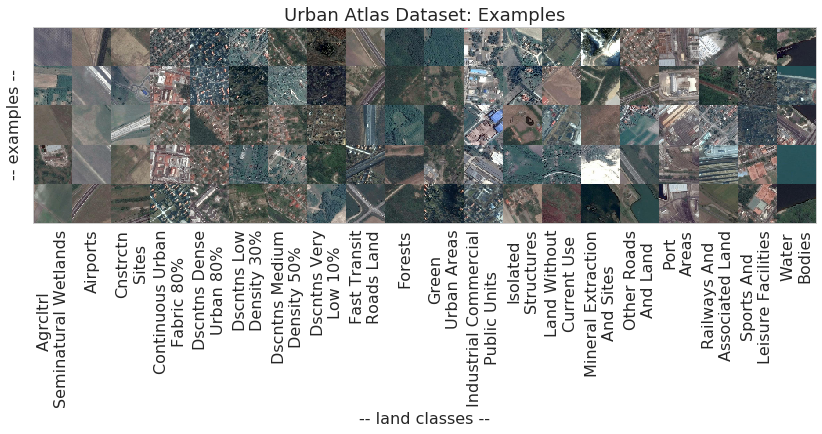

In [71]:
plot_examples(images, labels, nExamples=5, thumbSize = (50,50), title="Urban Atlas Dataset: Examples")